# Librerias

In [29]:
# pip install kymatio matplotlib seaborn scikit-learn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE

from kymatio.sklearn import Scattering2D

# Visualización e Inicialización

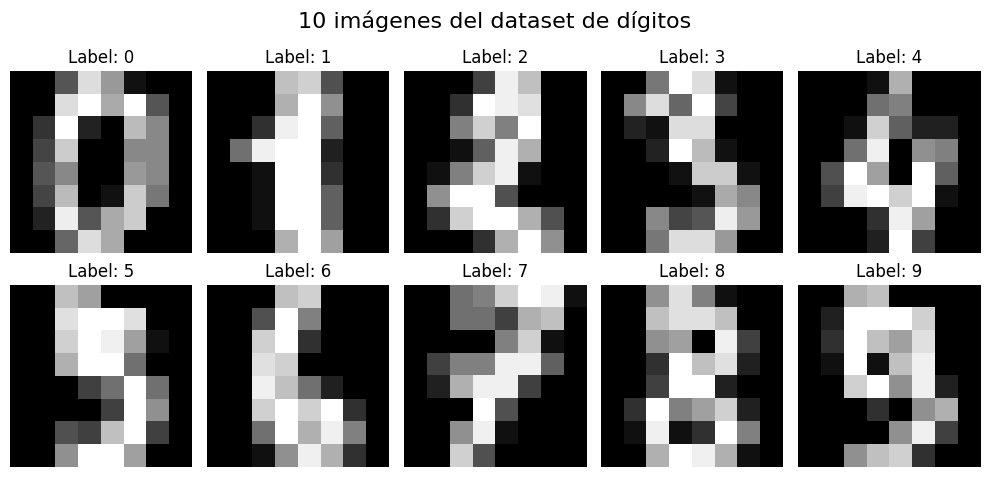

Dimensiones de la salida de la transformada WST2D: (1797, 112)


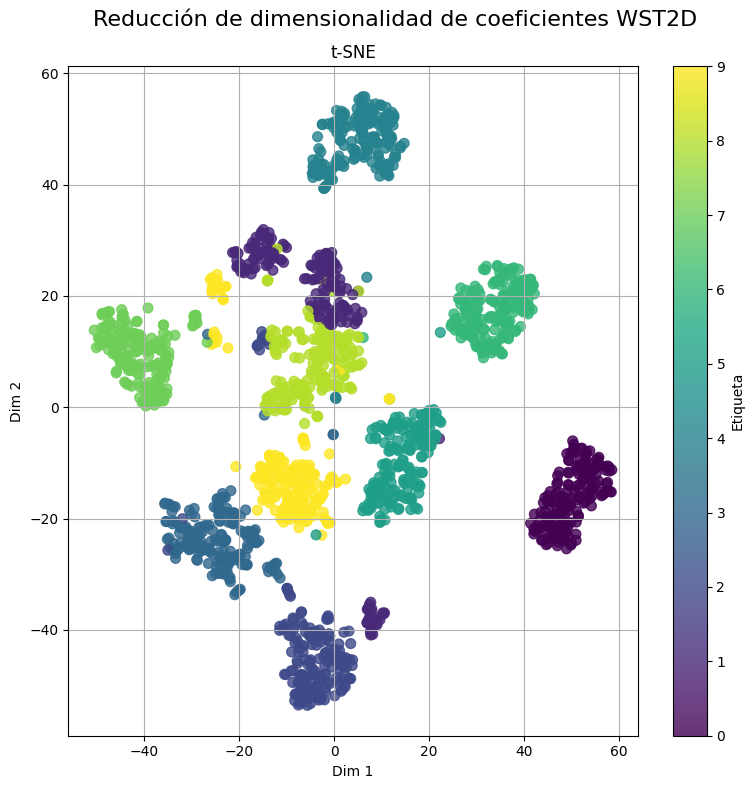

In [30]:
# -------------------------------
# 1. Carga y visualización del dataset
# -------------------------------

# Cargar el dataset de dígitos (imágenes de 8x8 píxeles)
digits = datasets.load_digits()
images = digits.images
labels = digits.target

# Graficar las primeras 10 imágenes
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"Label: {labels[i]}")
    ax.axis('off')
plt.suptitle("10 imágenes del dataset de dígitos", fontsize=16)
plt.tight_layout()
plt.show()


# Definir la transformación Scattering2D para imágenes de 8x8
scattering = Scattering2D(J=1, L=6, shape=(8, 8))

# Aplicar la transformada a todas las imágenes
X_scattering = scattering.transform(images)
print("Dimensiones de la salida de la transformada WST2D:", X_scattering.shape)

# Reducción con t-SNE
tsne = TSNE(n_components=2, random_state=42, init='pca')
X_tsne = tsne.fit_transform(X_scattering)

# Scattergram con t-SNE
plt.figure(figsize=(8,8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=50, alpha=0.8)
plt.title("t-SNE")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)

plt.suptitle("Reducción de dimensionalidad de coeficientes WST2D", fontsize=16)
plt.colorbar(orientation='vertical', label="Etiqueta")
plt.tight_layout()
plt.show()

# Train Test Split

In [31]:
# -------------------------------
# 2. División de datos
# -------------------------------

# Dividir el conjunto en entrenamiento y prueba (50% cada uno)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.5, shuffle=False)

print(f"Dimensiones del conjunto de entrenamiento: {X_train.shape}")
print(f"Dimensiones del conjunto de prueba: {X_test.shape}")

Dimensiones del conjunto de entrenamiento: (898, 8, 8)
Dimensiones del conjunto de prueba: (899, 8, 8)


# Pipeline

In [ ]:
# -------------------------------
# 3.Pipeline
# -------------------------------

# Definir la transformación Scattering2D
# scattering = Scattering2D(J=1, L=1, shape=(8, 8))

# Crear el pipeline que incluye:
# - Transformación Scattering2D
# - Escalado de características con StandardScaler
# - Clasificador (inicialmente se define LogisticRegression, pero se sustituirá mediante grid search)
pipeline = Pipeline([
    ('scattering', scattering),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())  # placeholder; se reemplazará en el grid search
])


In [33]:

# -------------------------------
# 4. Configuración de GridSearchCV para probar diferentes modelos y sus hiperparámetros
# -------------------------------

# Se define una lista de diccionarios para explorar distintos modelos y sus hiperparámetros
param_grid = [
    {   # Modelo: Logistic Regression
        'classifier': [LogisticRegression(max_iter=200)],
        'classifier__C': [0.1, 1, 10]
    },
    {   # Modelo: Support Vector Machine (SVM)
        'classifier': [SVC()],
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    },
    {   # Modelo: Random Forest
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [None, 10, 20]
    }
]

# Configurar GridSearchCV con validación cruzada de 3 pliegues
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)

# Ajustar el modelo con los datos de entrenamiento
grid.fit(X_train, y_train)

print("\nMejores parámetros encontrados:")
print(grid.best_params_)
print(f"Mejor precisión (score) en entrenamiento: {grid.best_score_:.4f}")

Fitting 3 folds for each of 15 candidates, totalling 45 fits

Mejores parámetros encontrados:
{'classifier': LogisticRegression(max_iter=200), 'classifier__C': 10}
Mejor precisión (score) en entrenamiento: 0.9352


# Evaluación

In [34]:
# -------------------------------
# 5. Evaluación del modelo en el conjunto de prueba
# -------------------------------

# Predecir en el conjunto de prueba
y_pred = grid.predict(X_test)

# Calcular la precisión en test
acc = accuracy_score(y_test, y_pred)
print(f"\nPrecisión en el conjunto de prueba: {acc*100:.2f}%")

# Reporte de clasificación
report = classification_report(y_test, y_pred)
print("\nClassification Report:")
print(report)


Precisión en el conjunto de prueba: 96.33%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        88
           1       0.98      0.90      0.94        91
           2       0.99      1.00      0.99        86
           3       0.99      0.93      0.96        91
           4       0.97      0.96      0.96        92
           5       0.95      0.99      0.97        91
           6       1.00      0.99      0.99        91
           7       0.99      0.97      0.98        89
           8       0.93      0.93      0.93        88
           9       0.88      0.98      0.93        92

    accuracy                           0.96       899
   macro avg       0.96      0.96      0.96       899
weighted avg       0.96      0.96      0.96       899



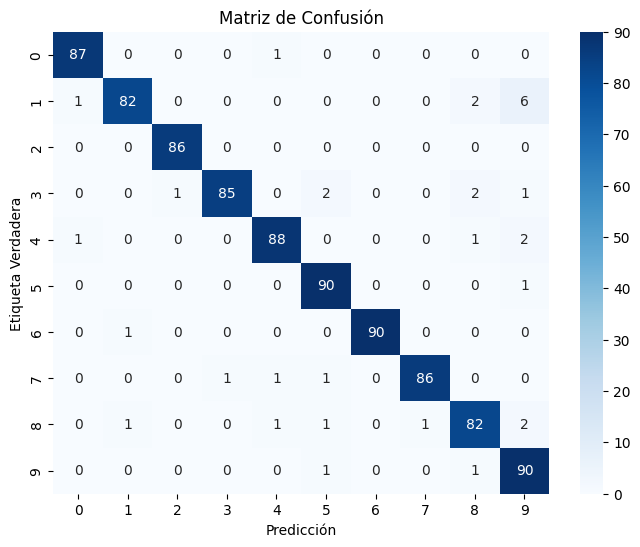

In [35]:
# -------------------------------
# 6. Visualización: Matriz de confusión
# -------------------------------

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Verdadera")
plt.show()

In [36]:
# -------------------------------
# 7. Visualización de resultados de GridSearchCV
# -------------------------------
# Se listan los resultados obtenidos para cada combinación de hiperparámetros
results = grid.cv_results_
print("Resultados detallados de GridSearchCV:")
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"Score: {mean_score:.4f} con parámetros: {params}")

Resultados detallados de GridSearchCV:
Score: 0.8983 con parámetros: {'classifier': LogisticRegression(max_iter=200), 'classifier__C': 0.1}
Score: 0.9261 con parámetros: {'classifier': LogisticRegression(max_iter=200), 'classifier__C': 1}
Score: 0.9352 con parámetros: {'classifier': LogisticRegression(max_iter=200), 'classifier__C': 10}
Score: 0.9204 con parámetros: {'classifier': SVC(), 'classifier__C': 0.1, 'classifier__kernel': 'linear'}
Score: 0.7671 con parámetros: {'classifier': SVC(), 'classifier__C': 0.1, 'classifier__kernel': 'rbf'}
Score: 0.9261 con parámetros: {'classifier': SVC(), 'classifier__C': 1, 'classifier__kernel': 'linear'}
Score: 0.8800 con parámetros: {'classifier': SVC(), 'classifier__C': 1, 'classifier__kernel': 'rbf'}
Score: 0.9261 con parámetros: {'classifier': SVC(), 'classifier__C': 10, 'classifier__kernel': 'linear'}
Score: 0.9316 con parámetros: {'classifier': SVC(), 'classifier__C': 10, 'classifier__kernel': 'rbf'}
Score: 0.8883 con parámetros: {'classifi

# FIN
---